In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

!pip freeze > requirements.txt

# Загрузка данных

Описания полей:

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту (target)

In [2]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
print('Соотношение количество значений 1 к количеству значений 0 в целевой переменной в тренировочной выборке:',
      int(df_train.default.value_counts()[1] / df_train.default.value_counts()[0] *100), '%')

Соотношение количество значений 1 к количеству значений 0 в целевой переменной в тренировочной выборке: 14 %


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [7]:
pd.read_csv('../input/sf-dst-scoring/sample_submission.csv')

FileNotFoundError: [Errno 2] File ../input/sf-dst-scoring/sample_submission.csv does not exist: '../input/sf-dst-scoring/sample_submission.csv'

Количество строк в тестовом датасете не соответствует количеству строк в sample_submission, что странно.

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [8]:
# Объединение тренировочной и тестовой выборки для совместной обработки.
# Для последующего разделения создаётся флаг is_test
df_train['is_test'] = 0
df_test['is_test'] = 1

df = pd.concat([df_train, df_test]).reset_index(drop=True) # без reset_index НЕ РАБОТАЕТ!!!!!!!!
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,is_test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0


In [9]:
df.tail()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,is_test
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,1
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,1
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,1
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,1
110147,69044,17MAR2014,SCH,M,38,N,N,0,0,-1.507549,2,50,1,2,15000,4,2,N,NaN,1


In [10]:
df.shape

(110148, 20)

# Заполнение пропусков

In [11]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
is_test                 0
dtype: int64

Пропуски содержатся только в признаке education.

In [12]:
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [13]:
# Пропущенные значения признака education заполняются модой
df.education[df.education.isna()] = df.education.mode()[0]

<ipython-input-13-6743dd20b659>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.education[df.education.isna()] = df.education.mode()[0]


In [14]:
df.isna().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
is_test                 0
dtype: int64

Пропуски ликвидированы

# Обработка даты

In [15]:
df.app_date = pd.to_datetime(df.app_date)
df.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [16]:
df.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

In [17]:
df[df.is_test==1].app_date.dt.month.value_counts()

3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64

Интервал дат в выборке: январь-апрель 2014. Даты распределены в тренировочной и в тестовой выборках примерно одинаково.

In [18]:
# новый признак: день недели подачи заявки
df['app_weekday'] = df.app_date.dt.weekday
df.app_weekday.value_counts()

1    18180
0    17858
2    17581
3    17421
4    16749
5    12202
6    10157
Name: app_weekday, dtype: int64

На выходные дни приходится значительно меньше заявок, чем на будни.

In [19]:
# преобразование даты в число
df.app_date = df.app_date.dt.strftime('%m%d').astype('int64')

In [20]:
# новый признак: количество заявок в данный день
apps_per_date = df.app_date.value_counts()

In [21]:
df['apps_per_day'] = df.app_date.map(apps_per_date)

# Разделение признаков на группы

In [22]:
# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные признаки
cat_cols = ['education', 'home_address', 'work_address',
        'sna', 'first_time',
            'app_weekday'
           ]

# числовые признаки
num_cols = ['app_date', 'age', 'decline_app_cnt', 'score_bki',
        'bki_request_cnt', 'region_rating', 'income',
            'apps_per_day'
           ]

# Обработка признаков

## Числовые признаки

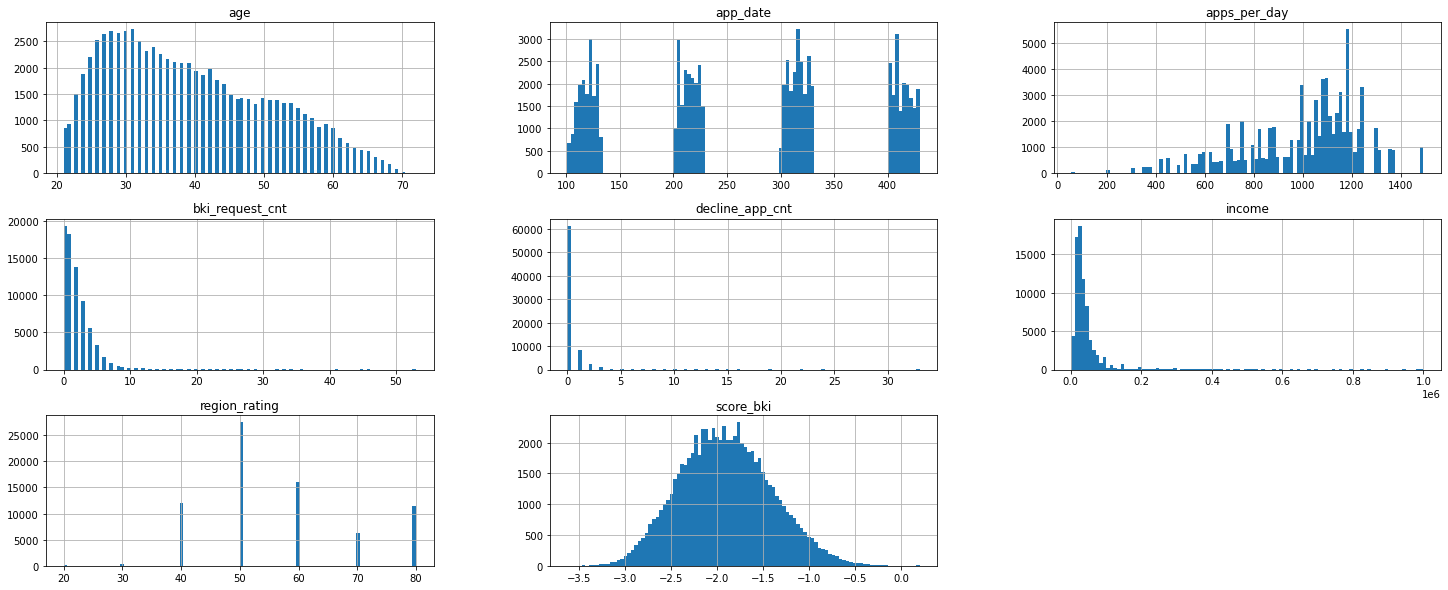

In [23]:
df[df.is_test == 0][num_cols].hist(figsize=(25,10),bins=100);

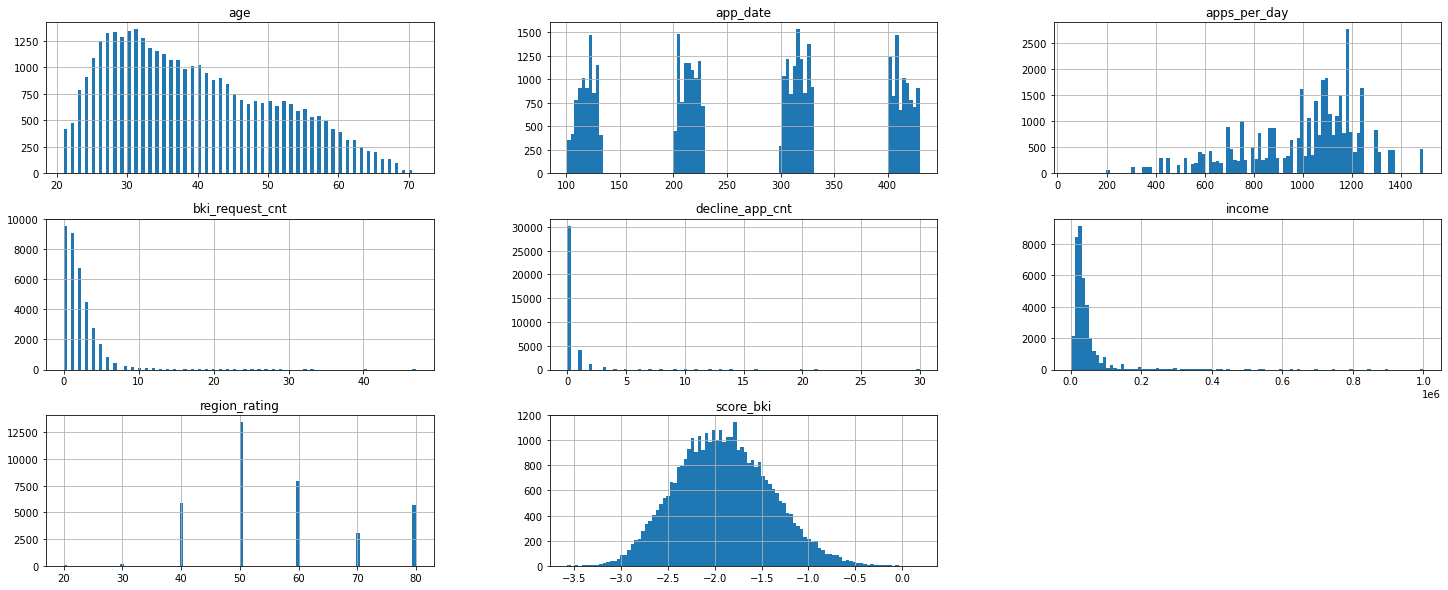

In [24]:
df[df.is_test == 1][num_cols].hist(figsize=(25,10),bins=100);

Распределение признаков в тренировочной и тестовой выборках одинаково.

<ipython-input-25-108fcbe9e560>:2: RuntimeWarning: invalid value encountered in log
  (np.log(df[num_cols]+1)).hist(figsize=(25,10),bins=100)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023ED79C46A0>,
      dtype=object)

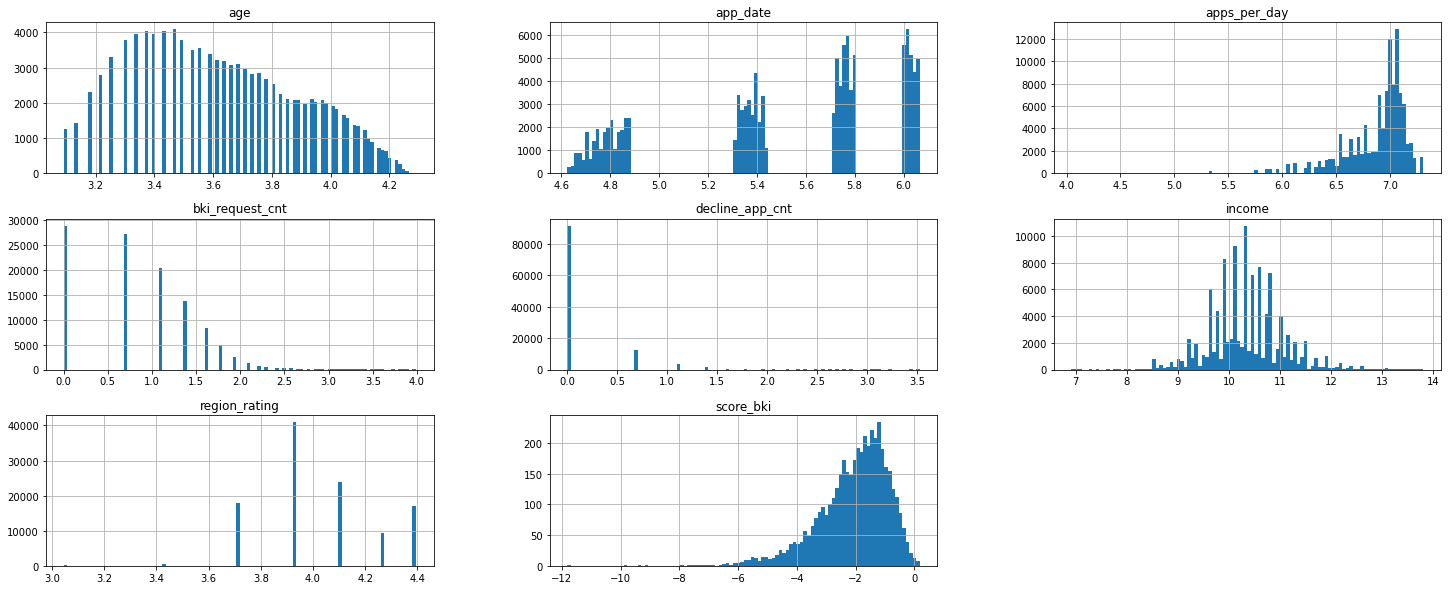

In [25]:
# попытка прологарифмировать признаки для приближения к виду нормального распределения
(np.log(df[num_cols]+1)).hist(figsize=(25,10),bins=100)

Некоторые признаки после логарифмирования выглядят более приближенными к виду нормального распеределения.

In [26]:
for i in ['age', 'bki_request_cnt', 'decline_app_cnt', 'income']:
    df[i] = np.log(df[i]+1)

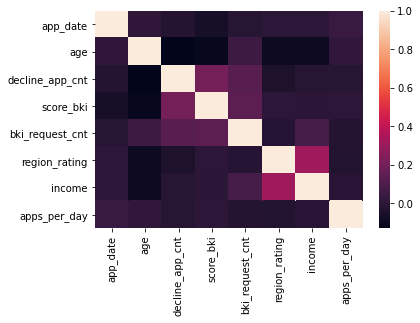

In [27]:
sns.heatmap(df[num_cols].corr())

Корреляции незначительны.

In [28]:
# # стандартизация:
sscaler = StandardScaler()
df[num_cols] = pd.DataFrame(sscaler.fit_transform(df[num_cols]),columns=num_cols)

In [29]:
df[num_cols].describe()

,app_date,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,apps_per_day
count,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05
mean,-1.173637e-16,1.004110e-15,-3.789093e-15,-4.903485e-16,3.587481e-16,-2.509444e-15,7.210120e-16,-2.744574e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.564737e+00,-1.976836e+00,-4.188152e-01,-3.444269e+00,-1.334144e+00,-2.812764e+00,-4.933787e+00,-4.029483e+00
25%,-6.173676e-01,-7.737452e-01,-4.188152e-01,-7.126592e-01,-1.334144e+00,-5.167044e-01,-6.348458e-01,-6.586749e-01
50%,3.207140e-01,-5.949589e-02,-4.188152e-01,-3.261521e-02,-2.817904e-01,-5.167044e-01,-5.283405e-02,2.904289e-01
75%,5.714883e-01,8.323877e-01,-4.188152e-01,6.741092e-01,7.705631e-01,2.486488e-01,6.218273e-01,7.245480e-01
max,1.490994e+00,2.230861e+00,9.340604e+00,4.213712e+00,4.722032e+00,1.779355e+00,4.980702e+00,2.077978e+00


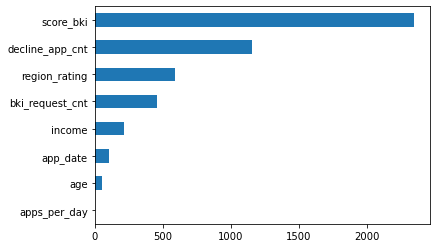

In [30]:
# оценка значимости числовых признаков:
imp_num = pd.Series(f_classif(df[df.is_test==0][num_cols], df[df.is_test==0]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из числовых признаков наиболее значимым является score_bki

## Бинарные признаки

In [31]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [32]:
# преобразование в числа
label_encoder = LabelEncoder()

for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023EDA0BD7F0>,
      dtype=object)

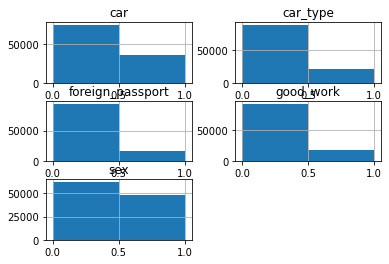

In [33]:
df[bin_cols].hist(bins=2)

In [34]:
df[bin_cols].describe()

,sex,car,car_type,good_work,foreign_passport
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,0.438610,0.325544,0.190725,0.165514,0.149136
std,0.496219,0.468580,0.392875,0.371645,0.356224
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
# # стандартизация:
# df[bin_cols] = pd.DataFrame(sscaler.fit_transform(df[bin_cols]),columns=bin_cols)

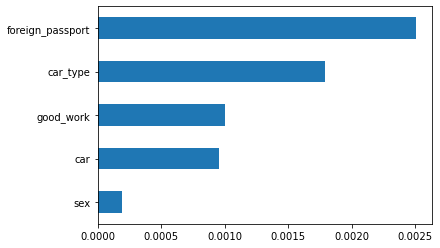

In [36]:
# оценка значимости бинарных признаков:
imp_cat = pd.Series(mutual_info_classif(df[df.is_test == 0][bin_cols], df[df.is_test == 0]['default'],
                                        discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Из бинарных признаков наиболее значимыми являются foreign_passport и car_type.

## Категориальные признаки

In [37]:
cat_cols

['education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'app_weekday']

In [38]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   education     110148 non-null  object
 1   home_address  110148 non-null  int64 
 2   work_address  110148 non-null  int64 
 3   sna           110148 non-null  int64 
 4   first_time    110148 non-null  int64 
 5   app_weekday   110148 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 5.0+ MB


In [39]:
df_train['education'].value_counts() / len(df_train)

SCH    0.526565
GRD    0.316603
UGR    0.133010
PGR    0.017033
ACD    0.002629
Name: education, dtype: float64

In [40]:
df_test['education'].value_counts() / len(df_test)

SCH    0.526507
GRD    0.313709
UGR    0.135685
PGR    0.016727
ACD    0.002669
Name: education, dtype: float64

In [41]:
df_dummies = pd.get_dummies(df[cat_cols].astype('object'))
df_dummies

,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,...,first_time_2,first_time_3,first_time_4,app_weekday_0,app_weekday_1,app_weekday_2,app_weekday_3,app_weekday_4,app_weekday_5,app_weekday_6
0,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
110144,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
110145,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
110146,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [42]:
dummy_cols = df_dummies.columns

In [43]:
df = pd.concat([df, df_dummies], axis=1)

In [44]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'is_test', 'app_weekday',
       'apps_per_day', 'education_ACD', 'education_GRD', 'education_PGR',
       'education_SCH', 'education_UGR', 'home_address_1', 'home_address_2',
       'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3',
       'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2',
       'first_time_3', 'first_time_4', 'app_weekday_0', 'app_weekday_1',
       'app_weekday_2', 'app_weekday_3', 'app_weekday_4', 'app_weekday_5',
       'app_weekday_6'],
      dtype='object')

In [45]:
df.drop(columns=cat_cols, inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  float64
 2   sex               110148 non-null  int32  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int32  
 5   car_type          110148 non-null  int32  
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  float64
 11  income            110148 non-null  float64
 12  foreign_passport  110148 non-null  int32  
 13  default           73799 non-null   float64
 14  is_test           110148 non-null  int64  
 15  apps_per_day      110148 non-null  float64
 16  education_ACD     11

In [47]:
cat_cols=dummy_cols

# Модель

In [48]:
x = df[df.is_test == 0].drop(columns=['client_id','default'])
y = df[df.is_test == 0]['default']

In [49]:
x_pred = df[df.is_test == 1].drop(columns=['client_id','default'])

In [50]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=13)

In [51]:
model = LogisticRegression(random_state=13, max_iter=1000, solver='lbfgs')
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=13)

In [52]:
probs = model.predict_proba(x_test)
probs = probs[:, 1]

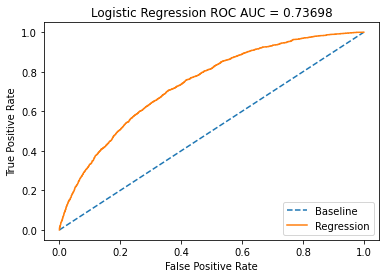

In [53]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [54]:
y_pred = model.predict(x_test)

In [55]:
pd.Series(y_pred).value_counts()

0.0    14633
1.0      127
dtype: int64

In [56]:
pd.Series(probs).describe()

count    14760.000000
mean         0.129362
std          0.102555
min          0.004447
25%          0.056563
50%          0.098425
75%          0.170583
max          0.762773
dtype: float64

In [57]:
confusion_matrix(y_test, y_pred)

array([[12850,    61],
       [ 1783,    66]], dtype=int64)

# Регуляризация

In [58]:
# Добавим типы регуляризации
penalty = ['l2']

In [59]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 2, 20)
C

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

In [60]:
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)


In [61]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
model = LogisticRegression(random_state=13, max_iter=1000, solver='lbfgs')
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)


In [62]:
best_model = clf.fit(x_train, y_train)

In [63]:
# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.2742749857031337


In [64]:
p = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']

In [65]:
model = LogisticRegression(penalty=p,C=c, random_state=13, max_iter=1000, solver='lbfgs')

In [66]:
model.fit(x_train, y_train)

LogisticRegression(C=1.2742749857031337, max_iter=1000, random_state=13)

In [67]:
probs = model.predict_proba(x_test)
probs = probs[:, 1]

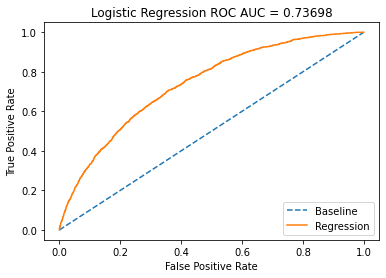

In [68]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Регуляризация не показала видимого улучшения качества модели.

In [69]:
y_pred = model.predict(x_test)

In [70]:
confusion_matrix(y_test, y_pred)

array([[12850,    61],
       [ 1783,    66]], dtype=int64)

# Результат

In [71]:
y_pred = model.predict(x_pred)
y_pred_proba = model.predict_proba(x_pred)

In [72]:
x_pred

,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time_2,first_time_3,first_time_4,app_weekday_0,app_weekday_1,app_weekday_2,app_weekday_3,app_weekday_4,app_weekday_5,app_weekday_6
73799,0.487897,1,-0.888776,1,1,-0.418815,0,-0.735587,0.770563,-0.516704,...,0,0,1,0,0,0,0,0,1,0
73800,-1.351115,0,0.120447,0,0,4.539989,0,0.800039,0.333797,-0.516704,...,0,1,0,0,0,0,0,1,0,0
73801,0.497185,1,0.972731,1,1,-0.418815,0,0.426908,-0.281790,-0.516704,...,0,1,0,0,0,0,0,0,0,1
73802,-0.617368,1,1.362924,0,0,-0.418815,0,-0.940432,-0.281790,-1.282058,...,0,1,0,1,0,0,0,0,0,0
73803,-0.608080,0,0.031629,0,0,-0.418815,0,-1.167347,-1.334144,1.779355,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0.571488,0,-0.059496,0,0,1.499512,0,0.319505,0.770563,-0.516704,...,0,0,0,1,0,0,0,0,0,0
110144,1.444554,0,1.823666,1,1,-0.418815,0,-0.779436,0.770563,0.248649,...,0,0,1,0,0,0,0,1,0,0
110145,0.562200,1,-0.662367,0,0,2.621662,0,1.929901,-0.281790,-0.516704,...,1,0,0,0,0,0,0,0,0,1
110146,-1.509010,0,-1.130811,0,0,1.499512,0,1.325890,0.333797,1.779355,...,0,0,0,0,1,0,0,0,0,0


In [73]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:
y_pred_proba[:,1]

array([0.04026953, 0.34357085, 0.06355177, ..., 0.34593068, 0.18496809,
       0.26348417])

In [75]:
len(y_pred)

36349

In [76]:
submission_proba = df_test.client_id.to_frame()
submission_proba['default'] = y_pred_proba[:,1]
submission_proba

,client_id,default
0,74835,0.040270
1,17527,0.343571
2,75683,0.063552
3,26883,0.090152
4,28862,0.025914
...,...,...
36344,83775,0.342792
36345,106254,0.015395
36346,81852,0.345931
36347,1971,0.184968


In [77]:
submission_proba.to_csv('submission.csv', index = False)